[link text](https://)  
#Experiment with P oversample , NP Regular 
###5 OM - Training - Decider, Library Management , Customer-Order , OnlineStore, E-commerce,
###2 OM - Testing - , Camping, Bank

## Setup (installing necessary libraries)

In [1]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

#Importing Libraries 

In [2]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

#Defining the Shapechecker

In [3]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Loading the Dataset

In [137]:
import pandas as pd
ORM_data = pd.read_csv('5_OM_Authentic_oversample_np_un.csv')


#Reading Dat from Dataset

In [138]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
1,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
2,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
3,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...
4,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...


In [139]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [140]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [141]:
target_raw =  Y
context_raw = X
#print(context_raw[-1])

In [142]:
#print(target_raw[-1])

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [143]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [144]:
for example_context_strings, example_target_strings in train_raw.take(1):
  #print(example_context_strings[:5])
  #print()
  #print(example_target_strings[:5])
  break

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [145]:
example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

#example_text = tf.constant('class1,table2,obj1,atr1')
#print(example_text.numpy())
#print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

In [146]:
#import re

#def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  #text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #pattern = '\s+'
  #re.split(pattern, text, maxsplit=2)
  #text = tf.strings.regex_replace(text, '\s+', '')
  #tf.strings.split(text, sep=', ', maxsplit=2, name=None)
  #tf.strings.split (text, sep='\s+', maxsplit=2, name=None)
  #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  #tf.strings.split(text, ',')
  #text = tf.strings.split(text, sep=None, maxsplit=-1, name=None)
  #text.tf.strings.split(', ')

  # Add spaces around punctuation.
  #text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  #text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  #return text

def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'\0')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text



In [147]:
#print(example_text.numpy().decode())
#print(tf_lower_and_split_punct(example_text).numpy().decode())

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [148]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [149]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
#context_text_processor.get_vocabulary()[:10]

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [150]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
#target_text_processor.get_vocabulary()[:10]

Now these layers can convert a batch of strings into a batch of token IDs:

In [151]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 75, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [152]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

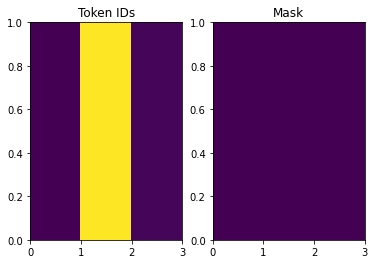

In [153]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [154]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [155]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 49  3]

[ 2 50]
[50  3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [156]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [157]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [158]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [159]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
       query=x,
       value=context,
      return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
  #Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [160]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                 output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [161]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

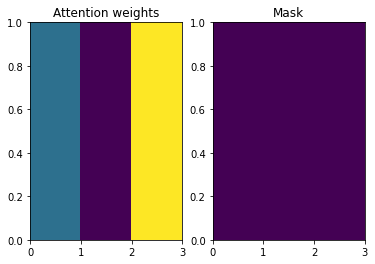

In [162]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [163]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [164]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [165]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [166]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 200)


#### Inference

For inference usage couple more methods.

In [167]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [168]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [169]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [170]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'moduleom_name:0,opendeclarationonesigclass1_nameextendsclassattrset=c1_at1id=c1_at1isabstract=nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsclassattrset=c01_at1id=c01_at1isabstract=nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsassociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsclassattrset=c2_at1id=c2_at1isabstract=nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1isabstract=nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsclassattrset=c4_at1oneparentid=c3_at1isabstract=noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsassociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsclassattrset

## The model


In [171]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [172]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 200)


### Train

In [173]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [174]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [175]:
model.compile(optimizer='Adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [176]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 5.2983174, 'expected_acc': 0.005}

That should roughly match the values returned by running a few steps of evaluation:

In [177]:
model.evaluate(val_ds, steps=40, return_dict=True)

40/40 [==============================] - 8s 13ms/step - loss: 5.2018 - masked_acc: 0.0125 - masked_loss: 5.2018


{'loss': 5.201776504516602,
 'masked_acc': 0.012500000186264515,
 'masked_loss': 5.201776504516602}

In [178]:
history = model.fit(
    train_ds.repeat(), 
    epochs=112,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 60,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/112
 99/100 [============================>.] - ETA: 0s - loss: 3.3175 - masked_acc: 0.4949 - masked_loss: 3.3175

100/100 [==============================] - 21s 60ms/step - loss: 3.3179 - masked_acc: 0.4950 - masked_loss: 3.3179 - val_loss: 3.1845 - val_masked_acc: 0.5093 - val_masked_loss: 3.1845
Epoch 2/112
 99/100 [============================>.] - ETA: 0s - loss: 3.2731 - masked_acc: 0.5000 - masked_loss: 3.2731

100/100 [==============================] - 3s 27ms/step - loss: 3.2847 - masked_acc: 0.5000 - masked_loss: 3.2847
Epoch 3/112
100/100 [==============================] - ETA: 0s - loss: 3.3221 - masked_acc: 0.5000 - masked_loss: 3.3221

100/100 [==============================] - 3s 27ms/step - loss: 3.3221 - masked_acc: 0.5000 - masked_loss: 3.3221
Epoch 4/112
100/100 [==============================] - ETA: 0s - loss: 3.0919 - masked_acc: 0.5000 - masked_loss: 3.0919

100/100 [==============================] - 3s 28ms/step - loss: 3.0919 - masked_acc: 0.5000 - masked_loss: 3.0919
Epoch 5/112
100/100 [==============================] - ETA: 0s - loss: 3.0772 - masked_acc: 0.5000 - masked_loss: 3.0772

100/100 [==============================] - 4s 37ms/step - loss: 3.0772 - masked_acc: 0.5000 - masked_loss: 3.0772
Epoch 6/112
 99/100 [============================>.] - ETA: 0s - loss: 2.6279 - masked_acc: 0.5404 - masked_loss: 2.6279

100/100 [==============================] - 4s 42ms/step - loss: 2.6198 - masked_acc: 0.5400 - masked_loss: 2.6198
Epoch 7/112
 99/100 [============================>.] - ETA: 0s - loss: 2.5460 - masked_acc: 0.5404 - masked_loss: 2.5460

100/100 [==============================] - 3s 27ms/step - loss: 2.5467 - masked_acc: 0.5400 - masked_loss: 2.5467
Epoch 8/112
 99/100 [============================>.] - ETA: 0s - loss: 2.6582 - masked_acc: 0.5202 - masked_loss: 2.6582

100/100 [==============================] - 3s 26ms/step - loss: 2.6625 - masked_acc: 0.5200 - masked_loss: 2.6625
Epoch 9/112
100/100 [==============================] - ETA: 0s - loss: 2.2907 - masked_acc: 0.5300 - masked_loss: 2.2907

100/100 [==============================] - 3s 26ms/step - loss: 2.2907 - masked_acc: 0.5300 - masked_loss: 2.2907
Epoch 10/112
 99/100 [============================>.] - ETA: 0s - loss: 2.3821 - masked_acc: 0.5404 - masked_loss: 2.3821

100/100 [==============================] - 4s 36ms/step - loss: 2.3666 - masked_acc: 0.5400 - masked_loss: 2.3666
Epoch 11/112
100/100 [==============================] - ETA: 0s - loss: 2.2138 - masked_acc: 0.5400 - masked_loss: 2.2138

100/100 [==============================] - 4s 40ms/step - loss: 2.2138 - masked_acc: 0.5400 - masked_loss: 2.2138
Epoch 12/112
100/100 [==============================] - ETA: 0s - loss: 1.9456 - masked_acc: 0.5600 - masked_loss: 1.9456

100/100 [==============================] - 3s 26ms/step - loss: 1.9456 - masked_acc: 0.5600 - masked_loss: 1.9456
Epoch 13/112
100/100 [==============================] - ETA: 0s - loss: 1.8589 - masked_acc: 0.6000 - masked_loss: 1.8589

100/100 [==============================] - 3s 27ms/step - loss: 1.8589 - masked_acc: 0.6000 - masked_loss: 1.8589
Epoch 14/112
 98/100 [============================>.] - ETA: 0s - loss: 1.7208 - masked_acc: 0.6071 - masked_loss: 1.7208

100/100 [==============================] - 3s 26ms/step - loss: 1.7298 - masked_acc: 0.6050 - masked_loss: 1.7298
Epoch 15/112
100/100 [==============================] - ETA: 0s - loss: 1.5170 - masked_acc: 0.6400 - masked_loss: 1.5170

100/100 [==============================] - 4s 37ms/step - loss: 1.5170 - masked_acc: 0.6400 - masked_loss: 1.5170
Epoch 16/112
100/100 [==============================] - ETA: 0s - loss: 1.6278 - masked_acc: 0.6300 - masked_loss: 1.6278

100/100 [==============================] - 4s 39ms/step - loss: 1.6278 - masked_acc: 0.6300 - masked_loss: 1.6278
Epoch 17/112
100/100 [==============================] - ETA: 0s - loss: 1.3272 - masked_acc: 0.6550 - masked_loss: 1.3272

100/100 [==============================] - 3s 27ms/step - loss: 1.3272 - masked_acc: 0.6550 - masked_loss: 1.3272
Epoch 18/112
100/100 [==============================] - ETA: 0s - loss: 1.1479 - masked_acc: 0.7100 - masked_loss: 1.1479

100/100 [==============================] - 3s 27ms/step - loss: 1.1479 - masked_acc: 0.7100 - masked_loss: 1.1479
Epoch 19/112
100/100 [==============================] - ETA: 0s - loss: 1.1567 - masked_acc: 0.7150 - masked_loss: 1.1567

100/100 [==============================] - 5s 51ms/step - loss: 1.1567 - masked_acc: 0.7150 - masked_loss: 1.1567
Epoch 20/112
100/100 [==============================] - ETA: 0s - loss: 0.7085 - masked_acc: 0.8050 - masked_loss: 0.7085

100/100 [==============================] - 5s 48ms/step - loss: 0.7085 - masked_acc: 0.8050 - masked_loss: 0.7085
Epoch 21/112
 99/100 [============================>.] - ETA: 0s - loss: 0.8003 - masked_acc: 0.7677 - masked_loss: 0.8003

100/100 [==============================] - 3s 28ms/step - loss: 0.8065 - masked_acc: 0.7650 - masked_loss: 0.8065
Epoch 22/112
 99/100 [============================>.] - ETA: 0s - loss: 0.7682 - masked_acc: 0.7727 - masked_loss: 0.7682

100/100 [==============================] - 3s 27ms/step - loss: 0.7608 - masked_acc: 0.7750 - masked_loss: 0.7608
Epoch 23/112
 98/100 [============================>.] - ETA: 0s - loss: 0.4666 - masked_acc: 0.8980 - masked_loss: 0.4666

100/100 [==============================] - 3s 27ms/step - loss: 0.4713 - masked_acc: 0.8950 - masked_loss: 0.4713
Epoch 24/112
100/100 [==============================] - ETA: 0s - loss: 0.5095 - masked_acc: 0.8500 - masked_loss: 0.5095

100/100 [==============================] - 3s 34ms/step - loss: 0.5095 - masked_acc: 0.8500 - masked_loss: 0.5095
Epoch 25/112
 98/100 [============================>.] - ETA: 0s - loss: 0.3936 - masked_acc: 0.9133 - masked_loss: 0.3936

100/100 [==============================] - 5s 45ms/step - loss: 0.3862 - masked_acc: 0.9150 - masked_loss: 0.3862
Epoch 26/112
100/100 [==============================] - ETA: 0s - loss: 0.2230 - masked_acc: 0.9700 - masked_loss: 0.2230

100/100 [==============================] - 3s 26ms/step - loss: 0.2230 - masked_acc: 0.9700 - masked_loss: 0.2230
Epoch 27/112
 98/100 [============================>.] - ETA: 0s - loss: 0.2412 - masked_acc: 0.9337 - masked_loss: 0.2412

100/100 [==============================] - 3s 27ms/step - loss: 0.2412 - masked_acc: 0.9350 - masked_loss: 0.2412
Epoch 28/112
 99/100 [============================>.] - ETA: 0s - loss: 0.1203 - masked_acc: 0.9747 - masked_loss: 0.1203

100/100 [==============================] - 3s 26ms/step - loss: 0.1198 - masked_acc: 0.9750 - masked_loss: 0.1198
Epoch 29/112
100/100 [==============================] - ETA: 0s - loss: 0.1104 - masked_acc: 0.9850 - masked_loss: 0.1104

100/100 [==============================] - 4s 36ms/step - loss: 0.1104 - masked_acc: 0.9850 - masked_loss: 0.1104
Epoch 30/112
 99/100 [============================>.] - ETA: 0s - loss: 0.1279 - masked_acc: 0.9798 - masked_loss: 0.1279

100/100 [==============================] - 4s 43ms/step - loss: 0.1267 - masked_acc: 0.9800 - masked_loss: 0.1267
Epoch 31/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0576 - masked_acc: 0.9949 - masked_loss: 0.0576

100/100 [==============================] - 3s 28ms/step - loss: 0.0571 - masked_acc: 0.9950 - masked_loss: 0.0571
Epoch 32/112
100/100 [==============================] - ETA: 0s - loss: 0.0363 - masked_acc: 0.9900 - masked_loss: 0.0363

100/100 [==============================] - 3s 27ms/step - loss: 0.0363 - masked_acc: 0.9900 - masked_loss: 0.0363
Epoch 33/112
100/100 [==============================] - ETA: 0s - loss: 0.0386 - masked_acc: 0.9950 - masked_loss: 0.0386

100/100 [==============================] - 3s 27ms/step - loss: 0.0386 - masked_acc: 0.9950 - masked_loss: 0.0386
Epoch 34/112
100/100 [==============================] - ETA: 0s - loss: 0.0297 - masked_acc: 0.9950 - masked_loss: 0.0297

100/100 [==============================] - 4s 41ms/step - loss: 0.0297 - masked_acc: 0.9950 - masked_loss: 0.0297
Epoch 35/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0610 - masked_acc: 0.9899 - masked_loss: 0.0610

100/100 [==============================] - 4s 38ms/step - loss: 0.0605 - masked_acc: 0.9900 - masked_loss: 0.0605
Epoch 36/112
100/100 [==============================] - ETA: 0s - loss: 0.0381 - masked_acc: 0.9950 - masked_loss: 0.0381

100/100 [==============================] - 3s 27ms/step - loss: 0.0381 - masked_acc: 0.9950 - masked_loss: 0.0381
Epoch 37/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0361 - masked_acc: 0.9949 - masked_loss: 0.0361

100/100 [==============================] - 3s 27ms/step - loss: 0.0358 - masked_acc: 0.9950 - masked_loss: 0.0358
Epoch 38/112
 98/100 [============================>.] - ETA: 0s - loss: 0.0328 - masked_acc: 0.9949 - masked_loss: 0.0328

100/100 [==============================] - 3s 27ms/step - loss: 0.0323 - masked_acc: 0.9950 - masked_loss: 0.0323
Epoch 39/112
100/100 [==============================] - ETA: 0s - loss: 0.0282 - masked_acc: 0.9950 - masked_loss: 0.0282

100/100 [==============================] - 4s 42ms/step - loss: 0.0282 - masked_acc: 0.9950 - masked_loss: 0.0282
Epoch 40/112
100/100 [==============================] - ETA: 0s - loss: 0.0718 - masked_acc: 0.9800 - masked_loss: 0.0718

100/100 [==============================] - 4s 36ms/step - loss: 0.0718 - masked_acc: 0.9800 - masked_loss: 0.0718
Epoch 41/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0088 - masked_acc: 1.0000 - masked_loss: 0.0088

100/100 [==============================] - 3s 26ms/step - loss: 0.0087 - masked_acc: 1.0000 - masked_loss: 0.0087
Epoch 42/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0412 - masked_acc: 0.9899 - masked_loss: 0.0412

100/100 [==============================] - 3s 27ms/step - loss: 0.0409 - masked_acc: 0.9900 - masked_loss: 0.0409
Epoch 43/112
100/100 [==============================] - ETA: 0s - loss: 0.0267 - masked_acc: 0.9950 - masked_loss: 0.0267

100/100 [==============================] - 3s 28ms/step - loss: 0.0267 - masked_acc: 0.9950 - masked_loss: 0.0267
Epoch 44/112
100/100 [==============================] - ETA: 0s - loss: 0.0688 - masked_acc: 0.9850 - masked_loss: 0.0688

100/100 [==============================] - 5s 46ms/step - loss: 0.0688 - masked_acc: 0.9850 - masked_loss: 0.0688
Epoch 45/112
100/100 [==============================] - ETA: 0s - loss: 0.0464 - masked_acc: 0.9900 - masked_loss: 0.0464

100/100 [==============================] - 3s 31ms/step - loss: 0.0464 - masked_acc: 0.9900 - masked_loss: 0.0464
Epoch 46/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0267 - masked_acc: 0.9899 - masked_loss: 0.0267

100/100 [==============================] - 3s 27ms/step - loss: 0.0265 - masked_acc: 0.9900 - masked_loss: 0.0265
Epoch 47/112
 98/100 [============================>.] - ETA: 0s - loss: 0.0216 - masked_acc: 0.9898 - masked_loss: 0.0216

100/100 [==============================] - 3s 27ms/step - loss: 0.0212 - masked_acc: 0.9900 - masked_loss: 0.0212
Epoch 48/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0939 - masked_acc: 0.9798 - masked_loss: 0.0939

100/100 [==============================] - 3s 28ms/step - loss: 0.0930 - masked_acc: 0.9800 - masked_loss: 0.0930
Epoch 49/112
100/100 [==============================] - ETA: 0s - loss: 0.0256 - masked_acc: 0.9950 - masked_loss: 0.0256

100/100 [==============================] - 4s 43ms/step - loss: 0.0256 - masked_acc: 0.9950 - masked_loss: 0.0256
Epoch 50/112
 99/100 [============================>.] - ETA: 0s - loss: 0.1320 - masked_acc: 0.9697 - masked_loss: 0.1320

100/100 [==============================] - 3s 32ms/step - loss: 0.1308 - masked_acc: 0.9700 - masked_loss: 0.1308
Epoch 51/112
 98/100 [============================>.] - ETA: 0s - loss: 0.0496 - masked_acc: 0.9949 - masked_loss: 0.0496

100/100 [==============================] - 3s 27ms/step - loss: 0.0488 - masked_acc: 0.9950 - masked_loss: 0.0488
Epoch 52/112
100/100 [==============================] - ETA: 0s - loss: 0.4443 - masked_acc: 0.9050 - masked_loss: 0.4443

100/100 [==============================] - 3s 27ms/step - loss: 0.4443 - masked_acc: 0.9050 - masked_loss: 0.4443
Epoch 53/112
100/100 [==============================] - ETA: 0s - loss: 0.4548 - masked_acc: 0.8700 - masked_loss: 0.4548

100/100 [==============================] - 3s 28ms/step - loss: 0.4548 - masked_acc: 0.8700 - masked_loss: 0.4548
Epoch 54/112
 99/100 [============================>.] - ETA: 0s - loss: 0.6132 - masked_acc: 0.8535 - masked_loss: 0.6132

100/100 [==============================] - 5s 47ms/step - loss: 0.6107 - masked_acc: 0.8550 - masked_loss: 0.6107
Epoch 55/112
 99/100 [============================>.] - ETA: 0s - loss: 0.3916 - masked_acc: 0.8788 - masked_loss: 0.3916

100/100 [==============================] - 3s 30ms/step - loss: 0.3885 - masked_acc: 0.8800 - masked_loss: 0.3885
Epoch 56/112
100/100 [==============================] - ETA: 0s - loss: 0.3947 - masked_acc: 0.9050 - masked_loss: 0.3947

100/100 [==============================] - 3s 27ms/step - loss: 0.3947 - masked_acc: 0.9050 - masked_loss: 0.3947
Epoch 57/112
100/100 [==============================] - ETA: 0s - loss: 0.2572 - masked_acc: 0.9150 - masked_loss: 0.2572

100/100 [==============================] - 3s 27ms/step - loss: 0.2572 - masked_acc: 0.9150 - masked_loss: 0.2572
Epoch 58/112
100/100 [==============================] - ETA: 0s - loss: 0.2481 - masked_acc: 0.9400 - masked_loss: 0.2481

100/100 [==============================] - 3s 30ms/step - loss: 0.2481 - masked_acc: 0.9400 - masked_loss: 0.2481
Epoch 59/112
100/100 [==============================] - ETA: 0s - loss: 0.1634 - masked_acc: 0.9650 - masked_loss: 0.1634

100/100 [==============================] - 5s 49ms/step - loss: 0.1634 - masked_acc: 0.9650 - masked_loss: 0.1634
Epoch 60/112
100/100 [==============================] - ETA: 0s - loss: 0.1193 - masked_acc: 0.9700 - masked_loss: 0.1193

100/100 [==============================] - 3s 27ms/step - loss: 0.1193 - masked_acc: 0.9700 - masked_loss: 0.1193
Epoch 61/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0714 - masked_acc: 0.9747 - masked_loss: 0.0714

100/100 [==============================] - 3s 27ms/step - loss: 0.0708 - masked_acc: 0.9750 - masked_loss: 0.0708
Epoch 62/112
 99/100 [============================>.] - ETA: 0s - loss: 0.1298 - masked_acc: 0.9747 - masked_loss: 0.1298

100/100 [==============================] - 3s 30ms/step - loss: 0.1290 - masked_acc: 0.9750 - masked_loss: 0.1290
Epoch 63/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0564 - masked_acc: 0.9798 - masked_loss: 0.0564

100/100 [==============================] - 4s 36ms/step - loss: 0.0559 - masked_acc: 0.9800 - masked_loss: 0.0559
Epoch 64/112
100/100 [==============================] - ETA: 0s - loss: 0.0681 - masked_acc: 0.9750 - masked_loss: 0.0681

100/100 [==============================] - 4s 41ms/step - loss: 0.0681 - masked_acc: 0.9750 - masked_loss: 0.0681
Epoch 65/112
100/100 [==============================] - ETA: 0s - loss: 0.0455 - masked_acc: 0.9850 - masked_loss: 0.0455

100/100 [==============================] - 3s 28ms/step - loss: 0.0455 - masked_acc: 0.9850 - masked_loss: 0.0455
Epoch 66/112
100/100 [==============================] - ETA: 0s - loss: 0.0070 - masked_acc: 1.0000 - masked_loss: 0.0070

100/100 [==============================] - 3s 28ms/step - loss: 0.0070 - masked_acc: 1.0000 - masked_loss: 0.0070
Epoch 67/112
100/100 [==============================] - ETA: 0s - loss: 0.0256 - masked_acc: 0.9900 - masked_loss: 0.0256

100/100 [==============================] - 3s 27ms/step - loss: 0.0256 - masked_acc: 0.9900 - masked_loss: 0.0256
Epoch 68/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0384 - masked_acc: 0.9899 - masked_loss: 0.0384

100/100 [==============================] - 4s 44ms/step - loss: 0.0380 - masked_acc: 0.9900 - masked_loss: 0.0380
Epoch 69/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0031 - masked_acc: 1.0000 - masked_loss: 0.0031

100/100 [==============================] - 4s 35ms/step - loss: 0.0032 - masked_acc: 1.0000 - masked_loss: 0.0032
Epoch 70/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0237 - masked_acc: 0.9949 - masked_loss: 0.0237

100/100 [==============================] - 3s 28ms/step - loss: 0.0234 - masked_acc: 0.9950 - masked_loss: 0.0234
Epoch 71/112
100/100 [==============================] - ETA: 0s - loss: 0.0273 - masked_acc: 0.9900 - masked_loss: 0.0273

100/100 [==============================] - 4s 42ms/step - loss: 0.0273 - masked_acc: 0.9900 - masked_loss: 0.0273
Epoch 72/112
100/100 [==============================] - ETA: 0s - loss: 0.0248 - masked_acc: 0.9900 - masked_loss: 0.0248

100/100 [==============================] - 5s 47ms/step - loss: 0.0248 - masked_acc: 0.9900 - masked_loss: 0.0248
Epoch 73/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020

100/100 [==============================] - 4s 39ms/step - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020
Epoch 74/112
100/100 [==============================] - ETA: 0s - loss: 0.0482 - masked_acc: 0.9800 - masked_loss: 0.0482

100/100 [==============================] - 3s 29ms/step - loss: 0.0482 - masked_acc: 0.9800 - masked_loss: 0.0482
Epoch 75/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - masked_acc: 0.9899 - masked_loss: 0.0216

100/100 [==============================] - 3s 28ms/step - loss: 0.0214 - masked_acc: 0.9900 - masked_loss: 0.0214
Epoch 76/112
100/100 [==============================] - ETA: 0s - loss: 0.0250 - masked_acc: 0.9950 - masked_loss: 0.0250

100/100 [==============================] - 3s 27ms/step - loss: 0.0250 - masked_acc: 0.9950 - masked_loss: 0.0250
Epoch 77/112
100/100 [==============================] - ETA: 0s - loss: 0.0285 - masked_acc: 0.9850 - masked_loss: 0.0285

100/100 [==============================] - 4s 43ms/step - loss: 0.0285 - masked_acc: 0.9850 - masked_loss: 0.0285
Epoch 78/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0098 - masked_acc: 0.9949 - masked_loss: 0.0098

100/100 [==============================] - 4s 37ms/step - loss: 0.0097 - masked_acc: 0.9950 - masked_loss: 0.0097
Epoch 79/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0158 - masked_acc: 0.9949 - masked_loss: 0.0158

100/100 [==============================] - 3s 29ms/step - loss: 0.0157 - masked_acc: 0.9950 - masked_loss: 0.0157
Epoch 80/112
100/100 [==============================] - ETA: 0s - loss: 0.0276 - masked_acc: 0.9950 - masked_loss: 0.0276

100/100 [==============================] - 3s 29ms/step - loss: 0.0276 - masked_acc: 0.9950 - masked_loss: 0.0276
Epoch 81/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - masked_acc: 0.9949 - masked_loss: 0.0215

100/100 [==============================] - 3s 30ms/step - loss: 0.0213 - masked_acc: 0.9950 - masked_loss: 0.0213
Epoch 82/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0030 - masked_acc: 1.0000 - masked_loss: 0.0030

100/100 [==============================] - 5s 48ms/step - loss: 0.0029 - masked_acc: 1.0000 - masked_loss: 0.0029
Epoch 83/112
100/100 [==============================] - ETA: 0s - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013

100/100 [==============================] - 3s 28ms/step - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013
Epoch 84/112
100/100 [==============================] - ETA: 0s - loss: 0.0163 - masked_acc: 0.9950 - masked_loss: 0.0163

100/100 [==============================] - 3s 27ms/step - loss: 0.0163 - masked_acc: 0.9950 - masked_loss: 0.0163
Epoch 85/112
100/100 [==============================] - ETA: 0s - loss: 0.0251 - masked_acc: 0.9900 - masked_loss: 0.0251

100/100 [==============================] - 3s 27ms/step - loss: 0.0251 - masked_acc: 0.9900 - masked_loss: 0.0251
Epoch 86/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0256 - masked_acc: 0.9899 - masked_loss: 0.0256

100/100 [==============================] - 4s 35ms/step - loss: 0.0254 - masked_acc: 0.9900 - masked_loss: 0.0254
Epoch 87/112
100/100 [==============================] - ETA: 0s - loss: 0.0198 - masked_acc: 0.9950 - masked_loss: 0.0198

100/100 [==============================] - 4s 44ms/step - loss: 0.0198 - masked_acc: 0.9950 - masked_loss: 0.0198
Epoch 88/112
100/100 [==============================] - ETA: 0s - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014

100/100 [==============================] - 3s 27ms/step - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014
Epoch 89/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - masked_acc: 0.9848 - masked_loss: 0.0335

100/100 [==============================] - 3s 27ms/step - loss: 0.0332 - masked_acc: 0.9850 - masked_loss: 0.0332
Epoch 90/112
100/100 [==============================] - ETA: 0s - loss: 0.0151 - masked_acc: 0.9950 - masked_loss: 0.0151

100/100 [==============================] - 3s 27ms/step - loss: 0.0151 - masked_acc: 0.9950 - masked_loss: 0.0151
Epoch 91/112
100/100 [==============================] - ETA: 0s - loss: 0.0259 - masked_acc: 0.9900 - masked_loss: 0.0259

100/100 [==============================] - 4s 37ms/step - loss: 0.0259 - masked_acc: 0.9900 - masked_loss: 0.0259
Epoch 92/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020

100/100 [==============================] - 4s 40ms/step - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020
Epoch 93/112
100/100 [==============================] - ETA: 0s - loss: 0.0165 - masked_acc: 0.9950 - masked_loss: 0.0165

100/100 [==============================] - 3s 27ms/step - loss: 0.0165 - masked_acc: 0.9950 - masked_loss: 0.0165
Epoch 94/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0344 - masked_acc: 0.9899 - masked_loss: 0.0344

100/100 [==============================] - 3s 27ms/step - loss: 0.0340 - masked_acc: 0.9900 - masked_loss: 0.0340
Epoch 95/112
100/100 [==============================] - ETA: 0s - loss: 0.0195 - masked_acc: 0.9900 - masked_loss: 0.0195

100/100 [==============================] - 3s 28ms/step - loss: 0.0195 - masked_acc: 0.9900 - masked_loss: 0.0195
Epoch 96/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 0.0010

100/100 [==============================] - 4s 45ms/step - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 0.0010
Epoch 97/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0237 - masked_acc: 0.9899 - masked_loss: 0.0237

100/100 [==============================] - 4s 35ms/step - loss: 0.0235 - masked_acc: 0.9900 - masked_loss: 0.0235
Epoch 98/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0211 - masked_acc: 0.9949 - masked_loss: 0.0211

100/100 [==============================] - 3s 30ms/step - loss: 0.0209 - masked_acc: 0.9950 - masked_loss: 0.0209
Epoch 99/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0108 - masked_acc: 0.9949 - masked_loss: 0.0108

100/100 [==============================] - 3s 29ms/step - loss: 0.0107 - masked_acc: 0.9950 - masked_loss: 0.0107
Epoch 100/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0103 - masked_acc: 1.0000 - masked_loss: 0.0103

100/100 [==============================] - 3s 31ms/step - loss: 0.0102 - masked_acc: 1.0000 - masked_loss: 0.0102
Epoch 101/112
 99/100 [============================>.] - ETA: 0s - loss: 0.6072 - masked_acc: 0.8687 - masked_loss: 0.6072

100/100 [==============================] - 5s 46ms/step - loss: 0.6414 - masked_acc: 0.8650 - masked_loss: 0.6414
Epoch 102/112
 99/100 [============================>.] - ETA: 0s - loss: 1.9942 - masked_acc: 0.6010 - masked_loss: 1.9942

100/100 [==============================] - 3s 29ms/step - loss: 1.9816 - masked_acc: 0.6000 - masked_loss: 1.9816
Epoch 103/112
100/100 [==============================] - ETA: 0s - loss: 0.8998 - masked_acc: 0.7350 - masked_loss: 0.8998

100/100 [==============================] - 3s 27ms/step - loss: 0.8998 - masked_acc: 0.7350 - masked_loss: 0.8998
Epoch 104/112
 99/100 [============================>.] - ETA: 0s - loss: 0.4209 - masked_acc: 0.8687 - masked_loss: 0.4209

100/100 [==============================] - 3s 27ms/step - loss: 0.4244 - masked_acc: 0.8650 - masked_loss: 0.4244
Epoch 105/112
 99/100 [============================>.] - ETA: 0s - loss: 0.4214 - masked_acc: 0.8838 - masked_loss: 0.4214

100/100 [==============================] - 3s 33ms/step - loss: 0.4331 - masked_acc: 0.8800 - masked_loss: 0.4331
Epoch 106/112
100/100 [==============================] - ETA: 0s - loss: 0.4722 - masked_acc: 0.8600 - masked_loss: 0.4722

100/100 [==============================] - 5s 46ms/step - loss: 0.4722 - masked_acc: 0.8600 - masked_loss: 0.4722
Epoch 107/112
100/100 [==============================] - ETA: 0s - loss: 0.0646 - masked_acc: 0.9950 - masked_loss: 0.0646

100/100 [==============================] - 3s 27ms/step - loss: 0.0646 - masked_acc: 0.9950 - masked_loss: 0.0646
Epoch 108/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0873 - masked_acc: 0.9798 - masked_loss: 0.0873

100/100 [==============================] - 3s 28ms/step - loss: 0.0864 - masked_acc: 0.9800 - masked_loss: 0.0864
Epoch 109/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0407 - masked_acc: 0.9848 - masked_loss: 0.0407

100/100 [==============================] - 3s 27ms/step - loss: 0.0404 - masked_acc: 0.9850 - masked_loss: 0.0404
Epoch 110/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0313 - masked_acc: 0.9899 - masked_loss: 0.0313

100/100 [==============================] - 4s 37ms/step - loss: 0.0311 - masked_acc: 0.9900 - masked_loss: 0.0311
Epoch 111/112
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - masked_acc: 0.9899 - masked_loss: 0.0290

100/100 [==============================] - 5s 53ms/step - loss: 0.0287 - masked_acc: 0.9900 - masked_loss: 0.0287
Epoch 112/112
100/100 [==============================] - ETA: 0s - loss: 0.0038 - masked_acc: 1.0000 - masked_loss: 0.0038

100/100 [==============================] - 5s 46ms/step - loss: 0.0038 - masked_acc: 1.0000 - masked_loss: 0.0038


## Plotting the Loss from Training 

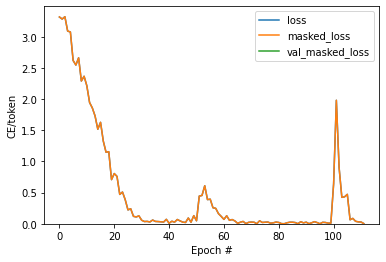

In [179]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Plotting the aacuracy from the training

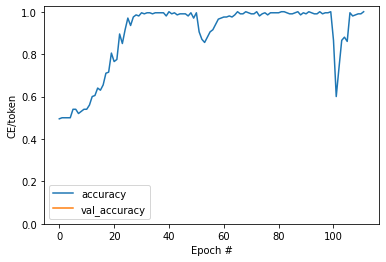

In [180]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate Module Development

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [181]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [182]:
#Individual translator mechanism, can be used to translate each data separately


result1 = model.translate([''])

result2 = model.translate([''])

result23 = model.translate([''])

result222 = model.translate([''])
#result1[0].numpy().decode()
#result2[0].numpy().decode()



### Attention plot generation after model training has been completed

In [183]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

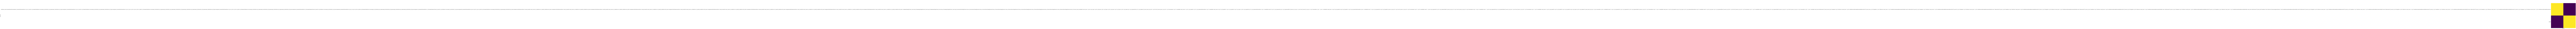

In [184]:
model.plot_attention('') 

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [185]:
long_text = context_raw[-1]

import textwrap
#print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

# Testing unseen samples

In [186]:
dc = pd.read_csv('bank_camping_samples.csv')

In [187]:
dc.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",0


### Separating Columns in X_test and y_test

In [188]:
X_test2 = dc['OM_Regular'].values
y_test2 = dc['OM_Prediction'].values

In [189]:
print(X_test2.shape)
print(y_test2.shape)

print("\nX data type: ", X_test2.dtype)
print("y data type: ", y_test2.dtype)

(61,)
(61,)

X data type:  object
y data type:  int64


In [190]:
print(y_test2)

[1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]


In [191]:
inputs = X_test2

### Obtaining results from the model of the unseen dataset

In [193]:
%%time
#for t in inputs:
  #mylist_res = model.translate([t])[0].numpy().decode()
#  print(model.translate([t])[0].numpy().decode())

#print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


# Classification Report (Unseen samples)


In [129]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

### The result is obtained and captured in a separate file, labels are converted to 1 and 0 . Where 1 denotes P and 0 denotes NP. 

###READING the predicted dataset

In [130]:
dd = pd.read_csv('bank_camping_samples_pred.csv')

In [131]:
dd.head()

,OM_Regular,OM_Prediction
0,"moduleom_name:0,opendeclarationonesigclass1_na...",0
1,"moduleom_name:0,opendeclarationonesigclass1_na...",0
2,"moduleom_name:0,opendeclarationonesigclass1_na...",0
3,"moduleom_name:0,opendeclarationonesigclass1_na...",0
4,"moduleom_name:0,opendeclarationonesigclass1_na...",0


In [132]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

### Printing predicted labels

In [133]:
print (y_test_pred2 )

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]


In [134]:
precision = precision_score(y_test2, y_test_pred2) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test2, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test2, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test2, y_test_pred2))

Testing: Precision = 0.818182
Testing: Recall = 0.428571
Testing: F1 Score = 0.562500

Confusion Matrix (Test Data):
 [[38  2]
 [12  9]]


In [135]:
print(classification_report(y_test2,y_test_pred2))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        40
           1       0.82      0.43      0.56        21

    accuracy                           0.77        61
   macro avg       0.79      0.69      0.70        61
weighted avg       0.78      0.77      0.75        61

